# PR-028 DenseNet

김성훈 교수님의 [DenseNet 강의](https://www.youtube.com/watch?v=fe2Vn0mwALI) 감사드립니다.

CIFAR10 데이터를 DenseNet 으로 학습시킵니다.

논문: https://arxiv.org/abs/1608.06993

### Prerequisite

<code> pip install opencv-python</code>

<code> pip install scikit-learn</code>

### Data Set
CIFAR-10 데이터는 케라스에서 손쉽게 쓸 수 있도록 api를 제공해 줍니다.

In [11]:
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical

import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalization
x_train = np.array(x_train) / 127.5 - 1
x_test = np.array(x_test) / 127.5 - 1

# one-hot encoding
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [2]:
import cv2
from sklearn.utils import shuffle

# trainval 데이터를 2배까지만 늘려 봅시다. - flip augmentation
flip_x = []
flip_y = []
for i in range(x_train.shape[0]):
    flip_x.append(cv2.flip(x_train[i], 1))
    flip_y.append(y_train[i])

flip_x = np.array(flip_x)
flip_y = np.array(flip_y)

x_train = np.concatenate((x_train, flip_x))
y_train = np.concatenate((y_train, flip_y))

x_train, y_train = shuffle(x_train, y_train)

### Build Model

논문에서는 크게 아래 사진과 같이 4개의 구조를 만들었습니다.

![image.png](DenseNet.png)

DenseNet-121 을 조금만 변형해서 사용해 봅니다.

input_shape 를 (32, 32, 3) 으로 입력시켜 주고

끝에 붙는 fully connected layer 의 크기를 10 으로 사용합니다.

In [3]:
from keras.models import Model
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.layers import Conv2D, Activation, Input, Dense
from keras.layers.pooling import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam

# hyperparameters
K = 32
init_ch = 64         # 가장 첫 layer의 채널 수 입니다.
compression = 0.5    # transition layer 에서의 channel을 얼마나 줄일 것인지 비율입니다. 논문에서도 0.5를 사용하였습니다.
inp_shape = (32, 32, 3)


# conv_layer를 간편하게 쓰기 위해 wrapper 입니다.
def conv_layer(x, filters, k, s):
    return Conv2D(filters,
                  kernel_size=(k, k),
                  strides=(s, s),
                  padding='same',
                  kernel_regularizer=l2(0.01))(x)

def dense_block(x, dense_block_size):
    for i in range(dense_block_size):
        tmp = x
        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, 4*K, 1, 1)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, K, 3, 1)
        
        x = concatenate([x, tmp])
        
    return x

def transition_block(x):
    shape = x.get_shape().as_list()                    # output 의 shape을 가져옵니다.
    compressed_channels = int(shape[3] * compression)  # compression 비율만큼 channel을 줄여 줍니다.
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv_layer(x, compressed_channels, 1, 1)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    return x

input_img = Input(inp_shape)

x = conv_layer(input_img, init_ch, 7, 2)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = dense_block(x, 6)
x = transition_block(x)

x = dense_block(x, 12)
x = transition_block(x)

x = dense_block(x, 24)
x = transition_block(x)

x = dense_block(x, 16)

x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='softmax')(x)

dense121 = Model(input_img, x)

dense121.summary() 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

### Train Model

In [6]:
# callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import math

def lr_schedule(epoch):
    return max(1e-5, 3e-4 * math.pow(0.7, epoch))

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint(filepath='model_{epoch:02d}.h5', 
                             save_best_only=True, 
                             save_weights_only=True)

In [7]:
dense121.compile(optimizer=Adam(0.0), loss='categorical_crossentropy', metrics=['accuracy'])

history = dense121.fit(x_train, y_train, 
                       epochs=100, 
                       batch_size=32, 
                       validation_split=0.2,
                       callbacks=[early_stopping, checkpoint, lr_scheduler])

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 376s 5ms/step - loss: 12.0048 - acc: 0.5027 - val_loss: 1.9106 - val_acc: 0.5346
Epoch 2/100
80000/80000 [==============================] - 286s 4ms/step - loss: 1.5173 - acc: 0.6354 - val_loss: 1.5683 - val_acc: 0.6171
Epoch 3/100
80000/80000 [==============================] - 284s 4ms/step - loss: 1.2366 - acc: 0.6987 - val_loss: 1.2227 - val_acc: 0.6984
Epoch 4/100
80000/80000 [==============================] - 281s 4ms/step - loss: 1.0433 - acc: 0.7484 - val_loss: 1.0691 - val_acc: 0.7308
Epoch 5/100
80000/80000 [==============================] - 286s 4ms/step - loss: 0.8989 - acc: 0.7851 - val_loss: 0.9015 - val_acc: 0.7779
Epoch 6/100
80000/80000 [==============================] - 289s 4ms/step - loss: 0.7852 - acc: 0.8174 - val_loss: 0.8422 - val_acc: 0.7951
Epoch 7/100
80000/80000 [==============================] - 290s 4ms/step - loss: 0.6817 - acc: 0.8484 - val_loss: 0

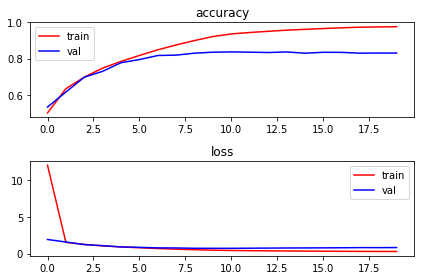

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Evaluate Model

In [12]:
score = dense121.evaluate(x_test, y_test)

print('test score:', score[0])
print('test accuracy:', score[1])

10000/10000 [==============================] - 6s 627us/step
test score: 0.944924238968
test accuracy: 0.808


모델이 overfitting 되었네요.

모델이 깊어서 parameter는 많은데, 데이터 셋은 작으니 일어나는 현상입니다.

실제로 사용하실 때는 랜덤 cropping 과 같은 augmentation 기법을 사용하여

많은 데이터로 학습시키시길 바랍니다.

## Contact me
케라스를 사랑하는 개발자 입니다.

질문, 조언, contribtuion 등 소통은 언제나 환영합니다.

Anthony Kim(김동현) : artit.anthony@gmail.com